# demo | **HAVOK analysis**
## Chaos as an intermittently forced linear system

*Ref*: [github@baronefr/rhavok-analysis](github.com/baronefr/rhavok-analysis)

In this notebook we explore the workflow of the paper **Chaos as an intermittently forced linear system** ([DOI: 10.1038/s41467-017-00030-8](https://www.nature.com/articles/s41467-017-00030-8)) from *S. Brunton et al*. As leading example, we apply the **HAVOK** technique to a Lorenz attractor with chaotic dynamics. HAVOK stands for *Hankel alternative view of Koopman*.

![workflow_image](./img/workflow_havok.svg)

In [1]:
import numpy as np

#%matplotlib widget
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.integrate import solve_ivp

plt.rcParams['font.size'] = 12
my_grey = (0.3,0.3,0.3)

import pandas as pd

import control # dynamic system simulation
import control.matlab as cnt

# routine | save figures
do_savefig = False
path_savefig = './img/havok_brunton_review/'

### Data import

We import the Lorenz attractor data. This ODE solution has been generated using the parameters
$\sigma = 10$, $\beta = 8/3$ and $\rho = 28$, with initial condition $x_0 = \left[ -8, 8, 27\right]$. The data is sampled with time step $dt=0.001$ using an ode45 solver.

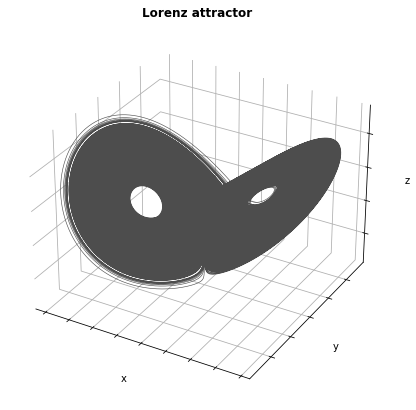

In [2]:
# load data from Lorenz attractor
xxn, yyn, zzn = np.load('./data/attractors/Lorenz_ext3000.npy')

dt = 0.001
N = len(xxn)
ttn = dt*(np.arange(N) + 1)

# plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

ax.plot(xxn, yyn, zzn, lw=0.6, c = my_grey )
plt.title('Lorenz attractor', fontweight='bold')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel('x');  ax.set_ylabel('y'); ax.set_zlabel('z');

fig.set_facecolor('w')
plt.setp(ax.get_xticklabels(), color="w")
plt.setp(ax.get_yticklabels(), color="w")
plt.setp(ax.get_zticklabels(), color="w")
if do_savefig: plt.savefig(path_savefig + 'lorenz_attractor.svg')
plt.show()

In [3]:
# select a coordinate for HAVOK analysis, which from now on
# will be called x, regardless of its origin

train_size = int(200/dt) # 200 seconds

x = xxn[:train_size]
tt = ttn[:train_size]

<br><br>

## Part 1 | **singular value decomposition**

### build the Hankel matrix

We reshape the input timeseries $x$ to fit in a **time delay coordinate** matrix. The Hankel matrix $H$ stacks in rows a shifted copy of the original timeseries:

$$
H = 
\left[
  \begin{array}{cccc}
    x(t_1) & x(t_2) & \ldots & x(t_p) \\
    x(t_2) & x(t_3) & \ldots & x(t_{p+1}) \\
    \vdots & & & \vdots \\
    x(t_{q}) & x(t_{q+1}) & \ldots & x(t_m)
  \end{array}
\right]
$$

In [4]:
# number of shift-stacked rows
q = 100

In [5]:
m = train_size
H = np.zeros((q, m-q+1))
for i in range(0, q):
    H[i,:] = x[ i:(m-q+1+i) ]
H.shape

(100, 199901)

### compute SVD

The SVD is a factorization of an input matrix $H$: $H = U\cdot \Sigma \cdot V^T$.

$$
H = 
\left[
  \begin{array}{ccc}
     \vdots &  & \vdots\\
     \vdots& U & \vdots\\
     \vdots &  & \vdots
  \end{array}
\right]
\left[
  \begin{array}{ccc}
    \ddots & 0 & 0\\
    0 & \Sigma & 0\\
    0 & 0 & \ddots
  \end{array}
\right]
\left[
  \begin{array}{ccccc}
    \dots & \dots& \dots& \dots & \dots\\
     & & V^T & & \\
    \dots & \dots& \dots& \dots & \dots
  \end{array}
\right]
$$

> The columns of $H$, are well-approximated by the ﬁrst $r$ columns of $U$, so these eigen-time-series provide a Koopman-invariant measurement system. The ﬁrst $r$ columns of $V$ provide a time series of the magnitude of each of the columns of $U\Sigma$ in the data. By plotting the ﬁrst three columns of $V$, we obtain an embedded attractor for the Lorenz system, shown in (see below).

In [6]:
u, sigma, vh = np.linalg.svd(H, full_matrices=False, compute_uv=True)

In [7]:
vh.shape

(100, 199901)

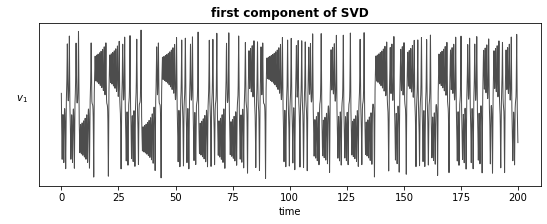

In [8]:
plt.figure( figsize=(9,3) )

plt.plot(tt[:len(vh[0])], vh[0], lw=1, c=my_grey)
plt.title('first component of SVD', fontweight='bold')
plt.xlabel('time')
plt.ylabel(r'   $v_1$         ', rotation=0)
plt.yticks([])
plt.show()

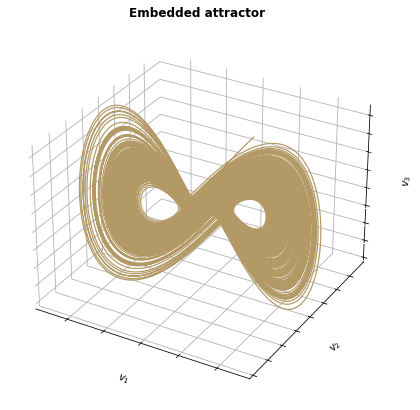

In [9]:
# plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

ax.plot(vh[0,:], vh[1,:], vh[2,:], lw=1.2, c = (0.7,0.6,0.4) )
plt.title('Embedded attractor', fontweight='bold')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel(r'$v_1$');  ax.set_ylabel(r'$v_2$'); ax.set_zlabel(r'$v_3$');

fig.set_facecolor('w')
plt.setp(ax.get_xticklabels(), color="w")
plt.setp(ax.get_yticklabels(), color="w")
plt.setp(ax.get_zticklabels(), color="w")
if do_savefig: plt.savefig(path_savefig + 'lorenz_embdedded.svg')
plt.show()

<br><br>

## Part 2 | **linear regression model**

We notice that the Hankel matrix avove can be rewritten in terms of the Koopman operator $\mathcal{K}$:
$$
H = 
\left[
  \begin{array}{cccc}
    x(t_1) & \mathcal{K}x(t_1) & \ldots & \mathcal{K}^{p-1}x(t_1) \\
    \mathcal{K}x(t_1) & \mathcal{K}^2x(t_1) & \ldots & \mathcal{K}^{p}x(t_1) \\
    \vdots & & \ddots & \vdots \\
    \mathcal{K}^{q-1}x(t_1) & \ldots & \ldots & \mathcal{K}^{m-1}x(t_1)
  \end{array}
\right]
$$

The connection between eigen-time-delay coordinates ($H$) and the Koopman operator motivates a linear regression model on the variables in $V$. Instead of performing the regression on the whole V matrix, we restrict to a fixed number $r$ of columns. Indeed, the first columns of $V$ are sorted such that they encode the most variance of patterns in the original data matrix.

Let us build a linear model on the first $r-1$ columns, while the last one, $v_r$, acts as a forcing term. Explicitly:

$$\frac{d}{dt}\mathbf{v}(t) = \mathbf{A} \mathbf{v}(t) + \mathbf{B} v_r(t) \;,$$ where $\mathbf{v} = \left[ v_1\;v_2\; \dots v_{r-1} \right](t)$ is a vector of the first $r-1$ eigen-time-delay coordinates (columns of $V$). $v_r$is reffered as *forcing* term.

We will perform the sparse regression using **SINDy** (Sparse Identification of Nonlinear Dynamics) on the $\mathbf{v}$ (embedded) coordinates.

### fix number of singular values

**Q**: How to fix $r$?

**Ans:** Try.

In [10]:
##   TODO (...)
r = 15

#  you eventually select the rows using   vh[0:r]

### compute the derivative

SINDy regression model requires the first derivative of input data to perform the sparse regression. Instead of computing the derivative using pairwise difference (divided by the time step), it is numerically more stable to compute it using a convolution of higher order. As done by Brunton et al, we will use the *fourth order central difference*.

$$ \frac{dx_i}{dt} = \frac{x_{i-2} - 8 x_{i+1} + 8 x_{i+1} - x_{i+2}}{12 dt}$$
for which we can prove that the error is of order $O(dt^4)$.

<br>

*Proof*:
Taylor expand $f(x+2h)$, $f(x+h)$, $f(x-h)$ and $f(x-2h)$. Then the linear combination $$-f(x+2h)+8f(x+h)-8f(x-h)+f(x-2h)$$ allows to cancel out the $3^{rd}$ order derivative from the expression. We get $$-f(x+2h)+8f(x+h)-8f(x-h)+f(x-2h) = (16-4)h\cdot f'(x) + O(h^4f^{(4)})$$ from which easily follows the thesis.

In [11]:
lv = vh.shape[1]
dv_star = np.zeros( (lv-5,r) )
for i in range(2,lv-3):
    dv_star[i-2,0:r] = (1/(12*dt))*(-vh[0:r, i+2]+8*vh[0:r, i+1]-8*vh[0:r, i-1]+vh[0:r, i-2])
dv_star.shape

(199896, 15)

In [12]:
v_star = vh[0:r, 2:(dv_star.shape[0]+2)].T
v_star.shape

(199896, 15)

### create the candidate library $\Theta$

In [13]:
def SINDy_generate_library(yin,nVars=r):
    #  Dev Note: this implementation is not complete! It allows to generate only
    # degree-one polynomial Theta. Further implementations might require higher order Poly!
    n = yin.shape[0]
    yout = np.zeros( (n,1+nVars) )  # valid to poly order 1
    
    # poly order 0 (add bias term)
    yout[:,0] = np.ones((n))
    
    idx = 1
    # poly order 1
    for i in range(0, nVars):
        yout[:,idx] = yin[:,i]
        idx = idx+1
        
    # omitting higher poly order
    
    return yout

theta = SINDy_generate_library(v_star, r)
m = theta.shape[1]  # 16 values

# normalize theta
norm_theta = np.linalg.norm(theta,axis=0)  # keep this for later
theta = theta/norm_theta

### regression

To perform the **sparse regression**, we implement a custom algorythm, based on *sequential* iterations of *least squares* & hard-thresholding.

In [14]:
def sequential_threshold_least_squares(Theta, dXdt, thres, niter = 10, nleast=1):
    # SINDy optimization algorithm: sequential threshold least squares
    
    # initial guess: least squares
    Xi = np.linalg.lstsq(Theta, dXdt, rcond=None)[0]
    # ref https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
    
    for k in range(0, niter):       # repeat several times the thresholding
        mask_under_thres = (abs(Xi)<thres)
        Xi[mask_under_thres] = 0
        for j in range(0, nleast):  # repeat several times the least squares
            mask_above_thres = np.invert(mask_under_thres)
            # do again least squares
            Xi[mask_above_thres] = np.linalg.lstsq(Theta[:,mask_above_thres], 
                                                   dXdt, rcond=None )[0] 
    return Xi

In [15]:
lamb = 0   # threshold value

Xi = np.zeros( (m, r-1) )

for k in range(0, r-1):  # apply separately on each column of Xi
    Xi[:,k] = sequential_threshold_least_squares(theta, dv_star[:,k], lamb*(k+1), 1)
    
Xi.shape

(16, 14)

In [16]:
# normalize Xi on Theta's 2-norm
Xi = Xi/norm_theta[:,None]
Xi.shape

(16, 14)

In [17]:
A = Xi[1:,:].T
B = A[:,r-1]
A = A[:,:r-1]

B.shape = (r-1,1) # forcing matrix-like shape

<br><br>
#### visualize the regression

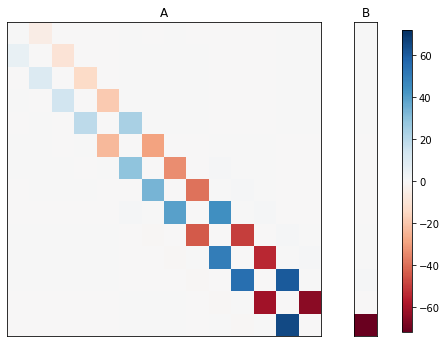

In [18]:
#plt.figure(figsize=(6,6))

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [14, 1]}, figsize=(7,6))
fig.tight_layout()

color_limit = max( np.ceil(np.abs(A).max()), np.ceil(np.abs(B).max()) )

im = ax[0].imshow(A, cmap='RdBu', interpolation='nearest', aspect='equal', 
                  vmin=-color_limit, vmax=color_limit)
ax[0].set(title='A')  # eventually   ylabel='$A$'
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[0].get_yticklabels(), visible=False)
ax[0].tick_params(axis='both', which='both', length=0)
 
ax[1].imshow(B, cmap='RdBu', interpolation='nearest', aspect='equal', 
             vmin=-color_limit, vmax=color_limit)
ax[1].set(title='B')
plt.setp(ax[1].get_xticklabels(), visible=False)
plt.setp(ax[1].get_yticklabels(), visible=False)
ax[1].tick_params(axis='both', which='both', length=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
if do_savefig: plt.savefig(path_savefig + 'lorenz_sindy_regression.svg')
plt.show()

> The regression model obtained for the Lorenz system is sparse, having a dominant off-diagonal structure. This HAVOK model is highly
structured, with skew symmetric entries that are nearly integer multiples of ﬁve.

In [19]:
# print A values in a nice way
#with np.printoptions(precision=2, suppress=True, formatter={'float': '{:0.2f}'.format}, linewidth=100):
#    print(A)

pd.DataFrame(A).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00,-5.12,-0.00,-0.12,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00
1,5.11,-0.01,-9.93,-0.00,-0.19,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00
2,-0.00,9.90,-0.02,-13.59,-0.00,0.25,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00
3,0.11,-0.05,13.53,-0.05,-18.93,0.00,0.33,0.00,0.01,-0.00,-0.00,-0.00,0.00,0.00
4,-0.01,0.15,-0.05,18.85,-0.03,23.28,0.00,0.41,0.00,-0.01,-0.00,-0.00,0.00,0.00
5,0.00,0.05,-0.19,0.09,-23.21,-0.04,-28.94,-0.00,-0.51,0.00,0.01,0.00,-0.00,-0.00
6,0.00,0.01,0.02,-0.30,0.02,28.91,-0.00,-33.56,-0.00,0.59,0.00,0.01,-0.00,-0.00
7,-0.00,0.01,0.00,0.01,-0.40,-0.01,33.56,-0.00,-39.30,0.00,0.69,0.00,-0.01,-0.00
8,-0.00,-0.04,-0.04,-0.08,-0.06,0.57,0.02,39.30,-0.02,44.03,0.00,0.78,-0.00,-0.01
9,0.01,0.05,0.06,0.10,0.09,-0.09,-0.62,-0.01,-43.96,-0.05,-49.90,-0.00,0.89,0.00


<br><br>

## Part 3 | **forcing term activity**

A simple criteria to infer when the Lorenz attractor is going to switch lobes is to hard-threshold the forcing term $v_r$, which exhibits a **bursting behaviour** that precedes lobe switching events.

In [20]:
# select a portion of dataset
L = 50000

v1 = v_star[0:L,0]
v2 = v_star[0:L,1]
v3 = v_star[0:L,2]
forcing = v_star[0:L,r-1]
forcing_t = dt*(np.arange(len(forcing)) + 1)

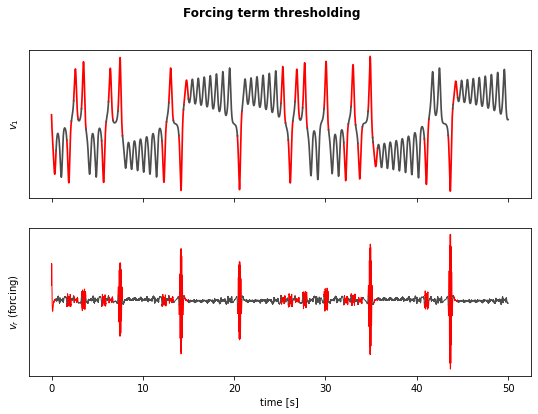

In [21]:
# thresholding + interval smoothing
thres = 0.002    # from paper: |v_r| > 0.002

above_thres = abs(forcing) > thres
thres_expand = 500
switch = False
for i in range(0,len(above_thres)):
    if above_thres[i]:
        if not switch:
            above_thres[i:i+thres_expand] = True
            switch = True
    else:
        switch = False


# plotting
fig, ax = plt.subplots(2, 1, figsize=(9,6))

yabove = np.ma.masked_where(np.invert(above_thres), v1)
ybelow = np.ma.masked_where(above_thres, v1)
ax[0].plot(forcing_t, yabove,  lw=1.7, c = 'red')
ax[0].plot(forcing_t, ybelow,  lw=1.7, c = my_grey)
ax[0].set(ylabel='$v_1$')
ax[0].set_yticks([])
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[0].get_yticklabels(), visible=False)

yabove = np.ma.masked_where(np.invert(above_thres), forcing)
ybelow = np.ma.masked_where(above_thres, forcing)
ax[1].plot(forcing_t, yabove,  lw=1, c = 'red')
ax[1].plot(forcing_t, ybelow,  lw=1, c = my_grey)
ax[1].set(ylabel='$v_r$ (forcing)')
ax[1].set_yticks([])

plt.xlabel('time [s]')
fig.suptitle('Forcing term thresholding', fontweight='bold')
if do_savefig: plt.savefig(path_savefig + 'lorenz_havok_thresholding.svg')
plt.show()

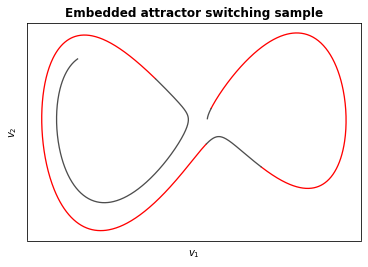

In [22]:
# plot
#plt.figure(figsize=(10, 7))
rgg = np.arange(1000,3000)  # select range

yabove1 = np.ma.masked_where(np.invert(above_thres)[rgg], v1[rgg])
yabove2 = np.ma.masked_where(np.invert(above_thres)[rgg], v2[rgg])
plt.plot(yabove1, yabove2,  lw=1.3, c = 'red')

ybelow1 = np.ma.masked_where(above_thres[rgg], v1[rgg])
ybelow2 = np.ma.masked_where(above_thres[rgg], v2[rgg])
plt.plot(ybelow1, ybelow2, lw=1.3, c = my_grey )

plt.xlabel(r'$v_1$');    plt.ylabel(r'$v_2$');
plt.xticks([]);          plt.yticks([]);
plt.title('Embedded attractor switching sample', fontweight='bold')
if do_savefig: plt.savefig(path_savefig + 'lorenz_havok_trajectory_switching.svg')
plt.show()

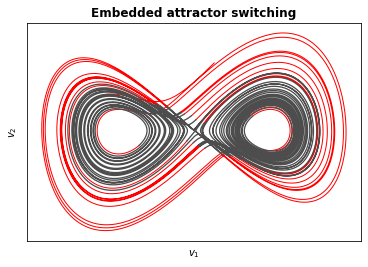

In [23]:
# plot
#plt.figure(figsize=(10, 7))
rgg = np.arange(0,len(v1))  # select range

yabove1 = np.ma.masked_where(np.invert(above_thres)[rgg], v1[rgg])
yabove2 = np.ma.masked_where(np.invert(above_thres)[rgg], v2[rgg])
yabove3 = np.ma.masked_where(np.invert(above_thres)[rgg], v3[rgg])
plt.plot(yabove1, yabove2,  lw=1, c = 'red')

ybelow1 = np.ma.masked_where(above_thres[rgg], v1[rgg])
ybelow2 = np.ma.masked_where(above_thres[rgg], v2[rgg])
ybelow3 = np.ma.masked_where(above_thres[rgg], v3[rgg])
plt.plot(ybelow1, ybelow2, lw=1.3, c = my_grey )

plt.xlabel(r'$v_1$');    plt.ylabel(r'$v_2$');
plt.xticks([]);          plt.yticks([]);
plt.title('Embedded attractor switching', fontweight='bold')

plt.show()

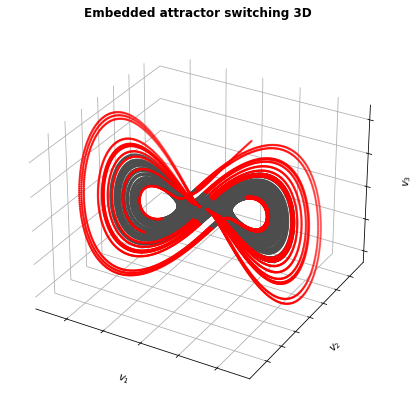

In [24]:
# plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

ax.scatter(yabove1, yabove2, yabove3, s=2, color = 'red')
ax.scatter(ybelow1, ybelow2, ybelow3, s=2, color = my_grey)
plt.title('Embedded attractor switching 3D', fontweight='bold')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.set_xlabel(r'$v_1$');  ax.set_ylabel(r'$v_2$'); ax.set_zlabel(r'$v_3$');

fig.set_facecolor('w')
plt.setp(ax.get_xticklabels(), color="w")
plt.setp(ax.get_yticklabels(), color="w")
plt.setp(ax.get_zticklabels(), color="w")

plt.show()

<br><br>

## Part 4 | **Moving window to compute embedded coordinates**

Once the SVD is performed, it is really easy to compute the embedded coordinates $\mathbf{v}$ using $U$.

#### note about the structure of U's columns

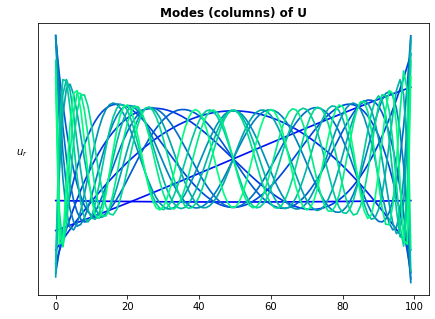

In [25]:
plt.figure( figsize=(7,5) )

colors = cm.winter(np.linspace(0, 1, r))

for rr in range(0,r):
    plt.plot(np.arange(len(u[:,rr])), u[:,rr], lw=1.7, c=colors[rr])

plt.title(r'Modes (columns) of U', fontweight='bold')
plt.ylabel(r'   $u_r$         ', rotation=0)
plt.yticks([])
if do_savefig: plt.savefig(path_savefig + 'lorenz_umodes.svg')
plt.show()

> The $U$ modes resemble polynomials, ordered by energy (i.e., constant, linear, quadratic, etc.). This structure in $U$ is common across most of the examples, and provides a criterion to determine the appropriate number of rows $q$ in $H$ and the rank $r$.

In [26]:
u_star = u[:,0:r]
u_star.shape

(100, 15)

### convolution with U

The forcing signature $v_{r}$ can be computed using a **moving window** about the input coordinate $x(t)$, doing a time convolution with $U$ (computed in SVD). Eventually, we could use the threshold method presented above to infer a prediction on chaotic behaviour (lobe switching in Lorenz) while observing its coordinate $x(t)$.

> Supplementary Figure 10: Modes $u_r$ (columns of the matrix U), indicating the short-time history
that must be convolved with $x(t)$ to obtain $v_r$.

> In practice, it is possible to measure $v_{15}$ from a streaming time series of $x(t)$ by convolution
with the $u_{15}$ mode (15th column in the matrix U), shown in Supplemental Figure 10.


#### step 1: initialize the moving window

In [27]:
mw = np.copy( x[:q] )
len(mw)

100

#### step 2: convolute

In [28]:
nsamples = 20000
vr_mw = np.zeros(nsamples)

for i in range(nsamples):
    # roll the moving window & add new coordinate
    mw = np.roll(mw, -1)
    mw[-1] = x[q+i+1]

    # compute the convolution
    vr_mw[i] = np.matmul(u[:,r-1], mw)/sigma[r-1]
    
tt_mw = np.arange(q, nsamples + q)*dt

offset = 200  # remove first samples
vr_mw = vr_mw[offset:]
tt_mw = tt_mw[offset:]

#### plot

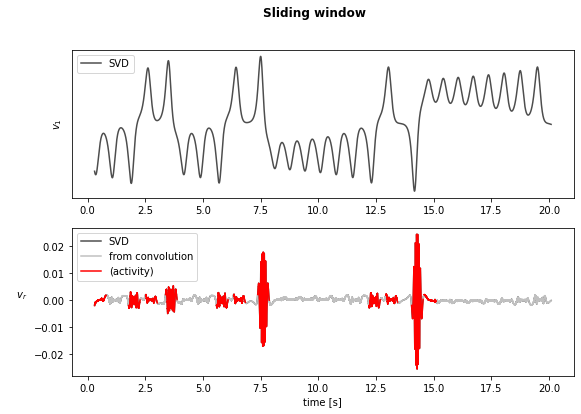

In [29]:
# plotting
fig, ax = plt.subplots(2, 1, figsize=(9,6))

ax[0].plot(tt_mw, v1[q+offset:len(tt_mw)+offset+q], lw=1.5, c=my_grey, label='SVD')
ax[0].set(ylabel='$v_1$')
ax[0].tick_params(axis='y', rotation=45)
ax[0].set_yticks([])
ax[0].legend()

thres = 0.002    # from paper: |v_r| > 0.002

above_thres = abs(vr_mw) > thres
thres_expand = 500
switch = False
for i in range(0,len(above_thres)):
    if above_thres[i]:
        if not switch:
            above_thres[i:i+thres_expand] = True
            switch = True
    else:
        switch = False
yabove = np.ma.masked_where(np.invert(above_thres), vr_mw)
ybelow = np.ma.masked_where(above_thres, vr_mw)

ax[1].plot(tt_mw, forcing[offset:len(tt_mw)+offset], lw=1.5, c=my_grey, label='SVD')
ax[1].plot(tt_mw, ybelow, lw=1.5, c='silver', label='from convolution')
ax[1].plot(tt_mw, yabove, lw=1.5, c='red', label='(activity)')
ax[1].legend(loc='upper left')

plt.xlabel('time [s]')
plt.ylabel(r'   $v_r$         ', rotation=0)
plt.suptitle('Sliding window', fontweight='bold')
if do_savefig: plt.savefig(path_savefig + 'lorenz_slidingwindow.svg')
plt.show()

<br><br>
## Part 5 | **HAVOK prediction in the Lorenz system**

We can use the model computed above (i.e. A, B and U) to reconstruct a dynamical system using $v_r$ as a forcing term.

In [30]:
sys = control.StateSpace(A, B, np.eye(r-1), 0*B)
forcing = v_star[0:L,r-1]
forcing_t = dt*(np.arange(len(forcing)) + 1)
x0 = v_star[0,0:r-1]
yout_test, T_test, xout_test = cnt.lsim(sys, forcing, forcing_t, x0)

In [31]:
v1_test = yout_test[:,0]
t_test = forcing_t

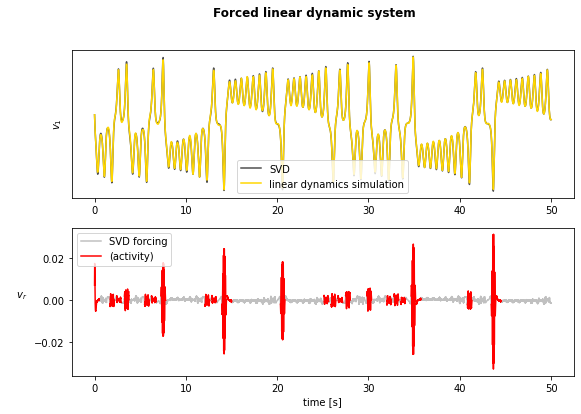

In [32]:
limiter = 50000
# plotting
fig, ax = plt.subplots(2, 1, figsize=(9,6))

ax[0].plot(t_test[:limiter], v_star[:limiter,0], lw=1.5, c=my_grey, label='SVD')
ax[0].plot(t_test[:limiter], v1_test[:limiter], lw=1.5, c='gold', 
           label='linear dynamics simulation')
ax[0].set(ylabel='$v_1$')
ax[0].tick_params(axis='y', rotation=45)
ax[0].set_yticks([])
ax[0].legend()

thres = 0.002    # from paper: |v_r| > 0.002

above_thres = abs(forcing[:limiter]) > thres
thres_expand = 500
switch = False
for i in range(0,len(above_thres)):
    if above_thres[i]:
        if not switch:
            above_thres[i:i+thres_expand] = True
            switch = True
    else:
        switch = False
yabove = np.ma.masked_where(np.invert(above_thres[:limiter]), forcing[:limiter])
ybelow = np.ma.masked_where(above_thres[:limiter], forcing[:limiter])

ax[1].plot(t_test[:limiter], ybelow, lw=1.5, c='silver', label='SVD forcing')
ax[1].plot(t_test[:limiter], yabove, lw=1.5, c='red', label='(activity)')
ax[1].legend(loc='upper left')

plt.xlabel('time [s]')
plt.ylabel(r'   $v_r$         ', rotation=0)
plt.suptitle('Forced linear dynamic system', fontweight='bold')
if do_savefig: plt.savefig(path_savefig + 'lorenz_simulation_train.svg')
plt.show()

### move forward in time: the test dataset

In [33]:
# compute v for the extended dataset (moving window)
mw = np.copy( xxn[(train_size-q):train_size] )

v_mw = np.zeros( (len(xxn)-train_size,r) )
for i in range(len(xxn)-train_size):
    # roll the moving window & add new coordinate
    mw = np.roll(mw, -1)
    mw[-1] = xxn[train_size+i]
    
    # compute the convolution
    v_mw[i] = np.matmul(u[:,0:r].T, mw)/sigma[0:r]  
tt_mw = np.arange(m, len(xxn))*dt

# v_mw is the test dataset

In [34]:
sys = control.StateSpace(A, B, np.eye(r-1), 0*B)

forcing = v_mw[:,-1]  # using v_r as forcing term
forcing_t = tt_mw[-len(forcing):]

x0 = v_star[-1,0:r-1] # the initial condition is the last embedded state
#                       of the train set

v_havok, _, _ = cnt.lsim(sys, forcing, forcing_t, x0)
v1_havok = v_havok[:,0]

# v_havok is the result from linear modeling of forcing term

In [35]:
# just parsing
t_test = forcing_t

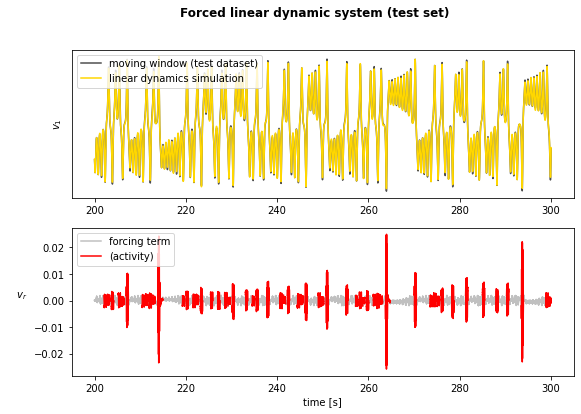

In [36]:
idx = np.arange(int(0/dt),int(100/dt))

# plotting
fig, ax = plt.subplots(2, 1, figsize=(9,6))

ax[0].plot(t_test[idx], v_mw[idx,0], lw=1.5, c=my_grey, label='moving window (test dataset)')
ax[0].plot(t_test[idx], v1_havok[idx], lw=1.5, c='gold', label='linear dynamics simulation')
ax[0].set(ylabel='$v_1$')
ax[0].tick_params(axis='y', rotation=45)
ax[0].set_yticks([])
ax[0].legend()

thres = 0.002    # from paper: |v_r| > 0.002

above_thres = abs(forcing[idx]) > thres
thres_expand = 500
switch = False
for i in range(0,len(above_thres)):
    if above_thres[i]:
        if not switch:
            above_thres[i:i+thres_expand] = True
            switch = True
    else:
        switch = False
yabove = np.ma.masked_where(np.invert(above_thres), forcing[idx])
ybelow = np.ma.masked_where(above_thres, forcing[idx])

ax[1].plot(t_test[idx], ybelow, lw=1.5, c='silver', label='forcing term')
ax[1].plot(t_test[idx], yabove, lw=1.5, c='red', label='(activity)')
ax[1].legend(loc='upper left')

plt.xlabel('time [s]')
plt.ylabel(r'   $v_r$         ', rotation=0)
plt.suptitle('Forced linear dynamic system (test set)', fontweight='bold')
if do_savefig: plt.savefig(path_savefig + 'lorenz_simulation_test.svg')
plt.show()

***

Code by *Francesco Barone*, last review: 30 may 2022. <br>**Workgroup**: Barone Francesco, Nagaro Gianmarco, Ninni Daniele, Valentini Lorenzo.

University of Padua, **Laboratory of Computational Physics**, module B.